In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import h5py
import matplotlib.pyplot as plt

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'


# 读取HDF5文件
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    # 假设第一个数据集是我们要看的
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())



数据集列表: ['Velocity_0001', 'Velocity_0002', 'Velocity_0003', 'Velocity_0004', 'Velocity_0005', 'Velocity_0006', 'Velocity_0007', 'Velocity_0008', 'Velocity_0009', 'Velocity_0010', 'Velocity_0011', 'Velocity_0012', 'Velocity_0013', 'Velocity_0014', 'Velocity_0015', 'Velocity_0016', 'Velocity_0017', 'Velocity_0018', 'Velocity_0019', 'Velocity_0020', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'

# 读取HDF5文件
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    # 假设第一个数据集是我们要看的
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
    
    # 归一化数据到 [0, 1] 范围
    data_normalized = (data[0] - data.min()) / (data.max() - data.min())
    
    # # 可视化数据中的第一个通道
    # plt.imshow(data_normalized[:, :, 0], cmap='viridis')
    # plt.title(f'{dataset_name} 第一个通道')
    # plt.colorbar()
    # plt.show()
    
    # # 可视化数据中的第二个通道
    # plt.imshow(data_normalized[:, :, 1], cmap='viridis')
    # plt.title(f'{dataset_name} 第二个通道')
    # plt.colorbar()
    # plt.show()
    
    # # 可视化数据中的第三个通道
    # plt.imshow(data_normalized[:, :, 2], cmap='viridis')
    # plt.title(f'{dataset_name} 第三个通道')
    # plt.colorbar()
    # plt.show()

数据集列表: ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


In [5]:
import h5py
import numpy as np

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'

# 读取HDF5文件并检查每个 Velocity 数据集的基本信息
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    for dataset_name in datasets:
        if 'Velocity' in dataset_name:
            data = f[dataset_name][()]
            print(f"{dataset_name} 数据形状:", data.shape)
            print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
            print(f"{dataset_name} 数据均值:", data.mean())
            print(f"{dataset_name} 数据标准差:", data.std())
            print()


数据集列表: ['Velocity_0001', 'Velocity_0002', 'Velocity_0003', 'Velocity_0004', 'Velocity_0005', 'Velocity_0006', 'Velocity_0007', 'Velocity_0008', 'Velocity_0009', 'Velocity_0010', 'Velocity_0011', 'Velocity_0012', 'Velocity_0013', 'Velocity_0014', 'Velocity_0015', 'Velocity_0016', 'Velocity_0017', 'Velocity_0018', 'Velocity_0019', 'Velocity_0020', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422
Velocity_0001 数据均值: 0.07109838
Velocity_0001 数据标准差: 0.6888756

Velocity_0002 数据形状: (1, 1024, 1024, 3)
Velocity_0002 数据范围: -2.7356367 到 2.7098155
Velocity_0002 数据均值: 0.07116876
Velocity_0002 数据标准差: 0.68889195

Velocity_0003 数据形状: (1, 1024, 1024, 3)
Velocity_0003 数据范围: -2.722479 到 2.7283216
Velocity_0003 数据均值: 0.07122495
Velocity_0003 数据标准差: 0.688922

Velocity_0004 数据形状: (1, 1024, 1024, 3)
Velocity_0004 数据范围: -2.7307792 到 2.74634
Velocity_0004 数据均值: 0.07126973
Velocity_0004 数据标准差: 0.6889681

Velocity_0005 数据形状: (1, 1024, 1024, 3)
Velocity_0

# 定义所需要的函数

## 计算涡度

In [6]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy


# 计算归一化的涡度
def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized


# 预训练模型测试新的湍流非对称数据集

读取约翰霍普金斯的湍流数据库

In [7]:
import h5py

import numpy as np
import matplotlib.pyplot as plt 

In [8]:
def downsample(image, size=(64, 64)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)


### 原始数据集

In [9]:
## 读取测试集

file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'

with h5py.File(file_path,'r') as f :
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    for dataset_name in datasets:
        if 'Velocity' in dataset_name:
            data = f[dataset_name][()]
            print(f"{dataset_name} 数据形状:", data.shape)
            print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
            print(f"{dataset_name} 数据均值:", data.mean())
            print(f"{dataset_name} 数据标准差:", data.std())
            print()

    data_normalized = (data[0] - data.min()) / (data.max() - data.min())

    data = f[dataset_name][()]

    u_test = data_normalized[:,:,0]
    v_test = data_normalized[:,:,1]
    w_test = data_normalized[:,:,2]



数据集列表: ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422
Velocity_0001 数据均值: 0.07109838
Velocity_0001 数据标准差: 0.6888756



### 降采样数据集 （64*64）

In [10]:
# 读取HDF5文件并降采样
with h5py.File(file_path, 'r') as f:
    # 获取所有速度场数据集名称
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    
    # 初始化空列表用于存储所有数据
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        # 取出三通道的速度场数据
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        # 降采样
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        # 将数据转换为PyTorch张量并增加batch和channel维度
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # 合并速度场作为输入
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        
        all_velocity_fields.append(velocity_field)
    
    # 将所有速度场数据合并为一个大的张量
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0)
    
    # 目标abcd (假设为0初始化)
    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32)
    
    # 创建数据集和数据加载器
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # 你可以根据需要调整batch_size

# 检查数据形状
print("all_velocity_fields shape:", all_velocity_fields.shape)
print("target_abcd shape:", target_abcd.shape)


all_velocity_fields shape: torch.Size([1, 3, 64, 64])
target_abcd shape: torch.Size([1, 4, 64, 64])


In [11]:
target_abcd.shape

torch.Size([1, 4, 64, 64])

In [12]:
all_velocity_fields[0,1,0,:].shape

torch.Size([64])

In [13]:
#可以查看数据范围，xyz都是（0，$2\pi$）
size_low = 64

dx = 2*np.pi/size_low
dy = 2*np.pi/size_low
dz = 2*np.pi/size_low

In [14]:
u_test =all_velocity_fields[0,0,:,:].numpy()
v_test =all_velocity_fields[0,1,:,:].numpy()
w_test =all_velocity_fields[0,2,:,:].numpy()

In [15]:
vort_test = vorticity(u_test, v_test, dx, dx)

vorticity_normalized = vorticity_normalize(vort_test)

print(vort_test.shape)
print(vorticity_normalized.shape)

(64, 64)
(64, 64)


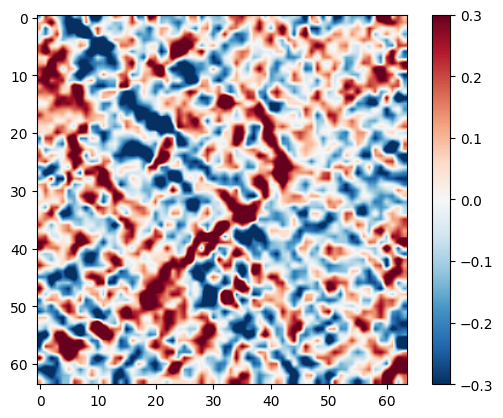

In [16]:
plt.imshow(vorticity_normalized, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()

u速度场形状 (64, 64)
v速度场形状 (64, 64)


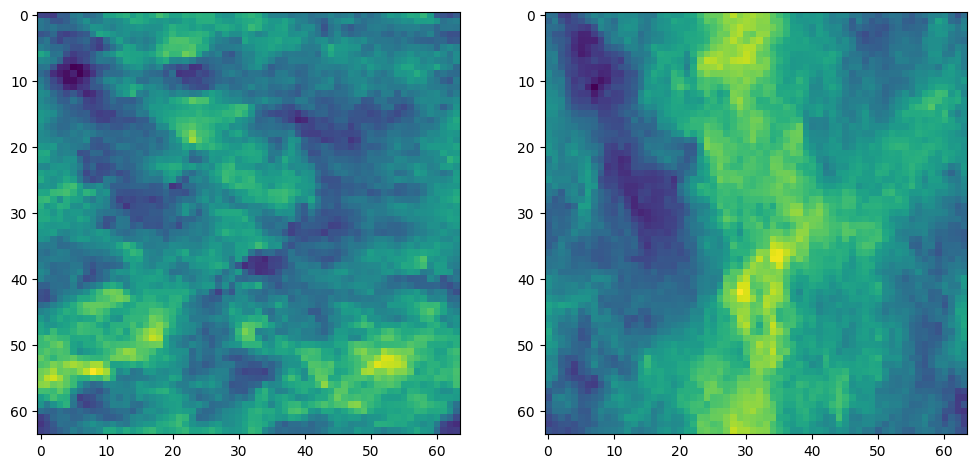

In [17]:
print("u速度场形状",u_test.shape) 
print("v速度场形状",v_test.shape)

# 查看一些速度场   
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)   
plt.imshow(u_test, cmap='viridis')   
plt.subplot(1, 2, 2)
plt.imshow(v_test, cmap='viridis')

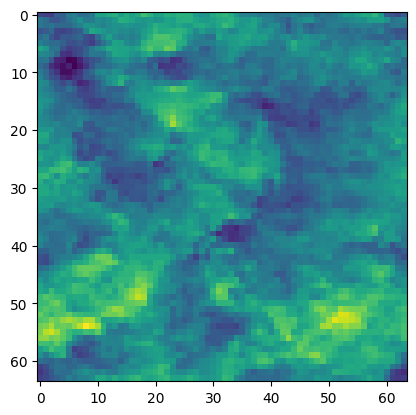

In [18]:
plt.imshow(u_test, cmap='viridis')

# 模型A部分尝试更换数据集

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [20]:
import h5py
import torch
from torch.utils.data import DataLoader, TensorDataset

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'

# 读取HDF5文件并降采样
with h5py.File(file_path, 'r') as f:
    # 获取所有速度场数据集名称
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    
    # 初始化空列表用于存储所有数据
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        # 取出三通道的速度场数据
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        # 降采样
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        # U_x_downsampled = U_x
        # U_y_downsampled = U_y
        # U_magnitude_downsampled = U_magnitude
        
        # 将数据转换为PyTorch张量并增加batch和channel维度
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # 合并速度场作为输入
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        
        all_velocity_fields.append(velocity_field)
    
    # 将所有速度场数据合并为一个大的张量
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0)
    
    # 目标abcd (假设为0初始化)
    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32)
    
    # 创建数据集和数据加载器
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)  # 调整批量大小

# 检查数据形状
print("all_velocity_fields shape:", all_velocity_fields.shape)
print("target_abcd shape:", target_abcd.shape)


all_velocity_fields shape: torch.Size([20, 3, 64, 64])
target_abcd shape: torch.Size([20, 4, 64, 64])


In [21]:
# 简单的模型
class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)  # 使用上采样恢复到原始尺寸
        x = self.conv5(x)
        return x


In [22]:
# 复杂的模型
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        
        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)  # Skip connection
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)  # Skip connection
        x = F.relu(self.bn7(self.conv7(x)))
        
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)  # Skip connection
        x = F.relu(self.bn8(self.conv8(x)))
        
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)  # Skip connection
        x = F.relu(self.bn9(self.conv9(x)))
        
        x = self.conv10(x)
        return x

In [23]:
class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        # 假设x的形状为 [batch_size, 4, height, width]，其中4代表abcd
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)  # 为了与abcd的四个通道对齐
        x = x / norm  # 归一化
        return x


In [24]:
class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x


In [25]:
def calculate_gradients_with_numpy(tensor):
    # 确保 Tensor 不需要梯度跟踪，且在 CPU 上
    tensor_np = tensor.detach().cpu().numpy()

    # 计算梯度
    grad_x = np.gradient(tensor_np, axis=1)  # 假设水平方向是 axis=1
    grad_y = np.gradient(tensor_np, axis=2)  # 假设垂直方向是 axis=2
    
    # 转换回 Tensor
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    
    return grad_x_tensor, grad_y_tensor


In [26]:
def laplacian_2d(array, dx, dy):
    grad_x = np.gradient(array, dx, axis=1, edge_order=2)  # 计算 x 方向的一阶导数
    grad_y = np.gradient(array, dy, axis=0, edge_order=2)  # 计算 y 方向的一阶导数
    
    laplacian_x = np.gradient(grad_x, dx, axis=1, edge_order=2)  # 计算 x 方向的二阶导数
    laplacian_y = np.gradient(grad_y, dy, axis=0, edge_order=2)  # 计算 y 方向的二阶导数
    
    return laplacian_x + laplacian_y



def laplacian_2d_torch(tensor, dx, dy):
    # 确保tensor是浮点类型，因为梯度计算通常需要浮点运算
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()

    # 计算x和y方向的一阶导数
    grad_x = np.gradient(tensor_np, axis=1)  # x方向
    grad_y = np.gradient(tensor_np, axis=2)  # y方向

    # 计算x和y方向的二阶导数
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)

    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)

    # 相加得到完整的拉普拉斯算子
    laplacian = laplacian_x_tensor + laplacian_y_tensor

    return laplacian


In [27]:
def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):
    # 提取 a, b, c, d
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    # 计算梯度
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1  # 你可以根据具体情况调整这个参数

    # 根据 a, b, c, d 计算预测的速度场
    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # 计算速度场的损失
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    loss_velocity = F.mse_loss(U_magnitude_pred, U_magnitude_true) + F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true)
    
    # 计算归一化约束
    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))
    
    # 计算拉普拉斯算子
    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    # 计算螺旋度约束
    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    # 计算L1正则化项
    l1_regularization = torch.tensor(0., requires_grad=True)
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())

    # 计算L2正则化项
    l2_regularization = torch.tensor(0., requires_grad=True)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    
    # 计算正则化项
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # 总损失
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization #+ norm_constraint + curl_constraint + regularization_term 
    return total_loss

In [28]:
from torch.cuda.amp import GradScaler, autocast

In [29]:
learning_rate = 0.0001
num_epochs = 10000
epsilon = 0.01
l1_lambda = 0.001  # L1正则化系数
l2_lambda = 0.001  # L2正则化系数


channels = 3

model = ComplexModelA()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
for epoch in range(num_epochs):
    for i, (velocity, _) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        # loss = loss_function(predicted_abcd, velocity, epsilon)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)

        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')

Epoch [1/10000], Step [1], Loss: 136.0502
Epoch [2/10000], Step [1], Loss: 120.1845
Epoch [3/10000], Step [1], Loss: 106.6357
Epoch [4/10000], Step [1], Loss: 94.1218
Epoch [5/10000], Step [1], Loss: 82.6118
Epoch [6/10000], Step [1], Loss: 72.1161
Epoch [7/10000], Step [1], Loss: 62.6522
Epoch [8/10000], Step [1], Loss: 54.2143
Epoch [9/10000], Step [1], Loss: 46.8180
Epoch [10/10000], Step [1], Loss: 40.4582
Epoch [11/10000], Step [1], Loss: 35.1332
Epoch [12/10000], Step [1], Loss: 30.7294
Epoch [13/10000], Step [1], Loss: 26.9261


KeyboardInterrupt: 

In [31]:
predicted_abcd[1,1,:,:].shape

torch.Size([64, 64])

In [32]:
a_pre = predicted_abcd[1,0,:,:].detach().cpu().numpy()
b_pre = predicted_abcd[1,1,:,:].detach().cpu().numpy()
c_pre = predicted_abcd[1,2,:,:].detach().cpu().numpy()
d_pre = predicted_abcd[1,3,:,:].detach().cpu().numpy()


In [33]:
a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)

In [34]:
# U_x_pred_test = a_pre * b_test_grad_x - b_pre * a_test_grad_x + c_pre * d_test_grad_x - d_pre * c_test_grad_x
# U_y_pred_test = a_pre * b_test_grad_y - b_pre * a_test_grad_y + c_pre * d_test_grad_y - d_pre * c_test_grad_y
# U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

In [35]:
U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

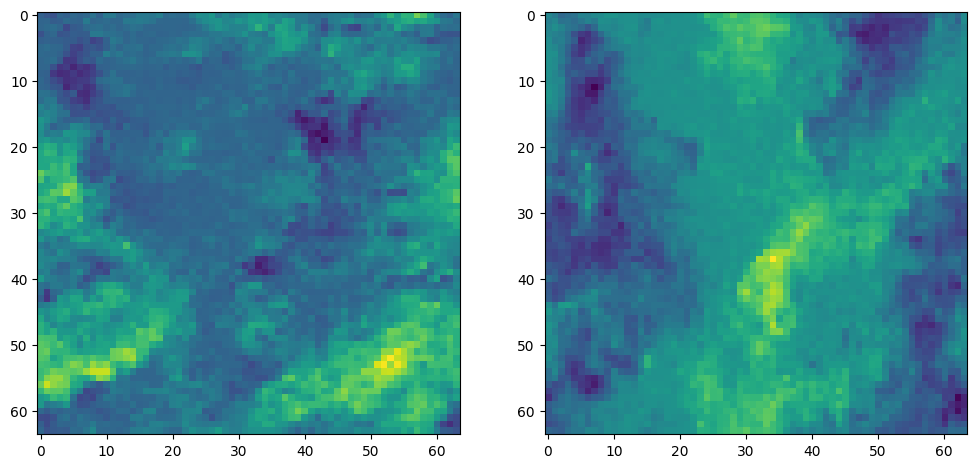

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
# plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')


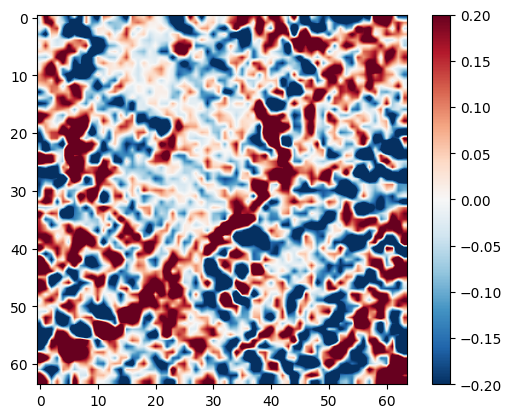

In [37]:
vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)

vorticity_normalized_pre = vorticity_normalize(vort_pre)

plt.imshow(vorticity_normalized_pre, cmap='RdBu_r',vmin=-0.2,vmax=0.2,interpolation='bilinear')
plt.colorbar()